In [1]:
import re
import pandas as pd
import numpy as np
import gensim
import nltk
# import spacy
import logging
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
from pprint import pprint
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.corpora import Dictionary
from gensim import corpora, models
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
%matplotlib inline

/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
np.random.seed(2018)
nltk.download('wordnet')
nltk.download('omw-1.4')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

[nltk_data] Downloading package wordnet to /Users/percyd/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/percyd/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
stemmer = SnowballStemmer('english')

In [4]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in simple_preprocess(text):
        if token not in STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [6]:
df = pd.read_csv('./output1.csv', parse_dates=['FRI_RELEASE_DAYBO', 'TUE_V_RELEASE'], error_bad_lines=False)

/var/folders/tl/jg9ncc9x4vnfwb17tjw2ms480000gn/T/ipykernel_71041/1950715145.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('./output1.csv', parse_dates=['FRI_RELEASE_DAYBO', 'TUE_V_RELEASE'], error_bad_lines=False)


In [7]:
df = df.drop('Unnamed: 0', axis=1)

In [8]:
test_df = df.loc[df['MOJO_title']=='Black Panther'].reset_index(drop=True)

In [9]:
test_df

,IMDB_ID,MOJO_title,FRI_RELEASE_DAYBO,TUE_V_RELEASE,imdb_url,user,user_url,review_date,review_title,review,review_len
0,tt1825683,Black Panther,2018-02-16,2018-05-08,https://www.imdb.com/title/tt1825683/reviews,Hitchcoc,http://imdb.com//user/ur0278527/?ref_=tt_urv,7 August 2020,Dull,I don't have a comic book background (well I d...,657
1,tt1825683,Black Panther,2018-02-16,2018-05-08,https://www.imdb.com/title/tt1825683/reviews,janmanuel2,http://imdb.com//user/ur42723874/?ref_=tt_urv,21 October 2018,I liked it at first.,I am between a 5 and a 6 on this. It was vastl...,406
2,tt1825683,Black Panther,2018-02-16,2018-05-08,https://www.imdb.com/title/tt1825683/reviews,Sleepin_Dragon,http://imdb.com//user/ur15311310/?ref_=tt_urv,5 April 2018,"I wish I enjoyed it like so many, it just bore...","I feel so bad giving this film a poor rating, ...",656
3,tt1825683,Black Panther,2018-02-16,2018-05-08,https://www.imdb.com/title/tt1825683/reviews,grantss,http://imdb.com//user/ur2860723/?ref_=tt_urv,10 November 2018,"Despite all the hype, pretty much your average...","After the death of his father, Prince T'Challa...",744
4,tt1825683,Black Panther,2018-02-16,2018-05-08,https://www.imdb.com/title/tt1825683/reviews,generationofswine,http://imdb.com//user/ur14520497/?ref_=tt_urv,18 February 2018,An Honest Review,"I guess, because of the hype, I was expecting ...",3428
...,...,...,...,...,...,...,...,...,...,...,...
3465,tt1825683,Black Panther,2018-02-16,2018-05-08,https://www.imdb.com/title/tt1825683/reviews,linagissberg,http://imdb.com//user/ur91552419/?ref_=tt_urv,23 August 2018,Glorious fantasy Africa!,People are generally too hard on this movie (o...,1104
3466,tt1825683,Black Panther,2018-02-16,2018-05-08,https://www.imdb.com/title/tt1825683/reviews,barkbarkbobo,http://imdb.com//user/ur92439754/?ref_=tt_urv,12 September 2018,"Fun, strong storyline, action-packed, beautiful",I just watched Black Panther for the first tim...,522
3467,tt1825683,Black Panther,2018-02-16,2018-05-08,https://www.imdb.com/title/tt1825683/reviews,qazwerty1,http://imdb.com//user/ur9511545/?ref_=tt_urv,13 May 2018,Really Good Marvel Movie,If you like Marvel super hero movies then you'...,229
3468,tt1825683,Black Panther,2018-02-16,2018-05-08,https://www.imdb.com/title/tt1825683/reviews,wfh-28059,http://imdb.com//user/ur99529011/?ref_=tt_urv,20 February 2019,Commentary on the Contemporary World,Today in the United States and around the worl...,3810


In [10]:
processed_docs = test_df['review'].map(preprocess)

In [11]:
processed_docs[:10]

0    [comic, book, background, year, film, predispo...
1    [vast, overr, profession, review, sure, review...
2    [feel, give, film, poor, rat, feel, import, re...
3    [death, father, princ, challa, ascend, throne,...
4    [guess, hype, expect, best, marvel, movi, best...
5    [black, panther, great, decept, viewer, brain,...
6    [want, black, panther, anticip, film, earli, h...
7    [suppos, newest, best, marvel, movi, suppos, d...
8    [hype, surround, movi, excel, trailer, kendric...
9    [cinematographi, film, obvious, come, expect, ...
Name: review, dtype: object

In [12]:
dictionary = Dictionary(processed_docs)

In [24]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [13]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [19]:
bigram = gensim.models.Phrases(processed_docs, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[processed_docs], threshold=100)

In [20]:
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [26]:
bow_doc_3000 = bow_corpus[3000]
data = []
weight = []
for i in range(len(bow_doc_3000)):
    weight.append(bow_doc_3000[i][1])
    data.append(dictionary[bow_doc_3000[i][0]])
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_3000[i][0], 
                                                     dictionary[bow_doc_3000[i][0]], 
                                                     bow_doc_3000[i][1]))

Word 21 ("littl") appears 1 time.
Word 34 ("think") appears 1 time.
Word 50 ("movi") appears 4 time.
Word 76 ("great") appears 2 time.
Word 95 ("action") appears 1 time.
Word 134 ("usual") appears 1 time.
Word 167 ("disappoint") appears 1 time.
Word 174 ("expect") appears 1 time.
Word 178 ("fair") appears 1 time.
Word 185 ("go") appears 1 time.
Word 236 ("tell") appears 1 time.
Word 237 ("time") appears 1 time.
Word 301 ("anticip") appears 1 time.
Word 305 ("begin") appears 1 time.
Word 358 ("good") appears 1 time.
Word 384 ("long") appears 1 time.
Word 397 ("open") appears 1 time.
Word 438 ("stori") appears 1 time.
Word 464 ("weekend") appears 1 time.
Word 472 ("enjoy") appears 1 time.
Word 541 ("famili") appears 1 time.
Word 566 ("line") appears 2 time.
Word 761 ("wish") appears 1 time.
Word 762 ("worth") appears 1 time.
Word 779 ("hour") appears 1 time.
Word 1068 ("wait") appears 2 time.
Word 2808 ("lengthi") appears 1 time.
Word 9546 ("squeal") appears 1 time.


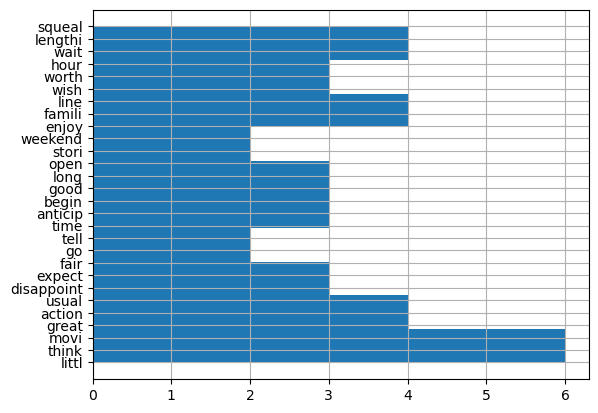

In [28]:
plt.hist(x=data, weights=weight, orientation='horizontal')
plt.grid()

In [34]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [35]:
LDA = models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [36]:
for idx, topic in LDA.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.021*"black" + 0.014*"panther" + 0.013*"wakanda" + 0.013*"marvel" + 0.012*"film" + 0.010*"african" + 0.009*"charact" + 0.009*"peopl" + 0.009*"killmong" + 0.008*"challa"
Topic: 1 
Words: 0.030*"film" + 0.026*"like" + 0.020*"marvel" + 0.018*"black" + 0.012*"good" + 0.012*"panther" + 0.010*"charact" + 0.010*"peopl" + 0.009*"action" + 0.009*"scene"
Topic: 2 
Words: 0.019*"like" + 0.017*"charact" + 0.017*"film" + 0.016*"marvel" + 0.013*"black" + 0.012*"great" + 0.012*"panther" + 0.011*"time" + 0.011*"good" + 0.010*"action"
Topic: 3 
Words: 0.032*"film" + 0.026*"black" + 0.018*"charact" + 0.018*"panther" + 0.011*"marvel" + 0.010*"like" + 0.009*"good" + 0.009*"wakanda" + 0.008*"best" + 0.008*"stori"
Topic: 4 
Words: 0.034*"black" + 0.017*"panther" + 0.014*"marvel" + 0.012*"challa" + 0.012*"film" + 0.011*"wakanda" + 0.010*"world" + 0.010*"peopl" + 0.009*"like" + 0.008*"watch"
Topic: 5 
Words: 0.029*"film" + 0.014*"black" + 0.012*"marvel" + 0.012*"like" + 0.012*"watch" + 0.012

In [40]:
lda_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)

In [39]:
for idx, topic in lda_tfidf.print_topics(-1):
    print('Topic: {} \nWord: {}'.format(idx, topic))

Topic: 0 
Word: 0.008*"film" + 0.005*"marvel" + 0.005*"watch" + 0.005*"good" + 0.005*"great" + 0.005*"bore" + 0.005*"action" + 0.005*"charact" + 0.005*"worst" + 0.005*"act"
Topic: 1 
Word: 0.007*"film" + 0.006*"like" + 0.005*"black" + 0.005*"marvel" + 0.004*"bore" + 0.004*"watch" + 0.004*"wakanda" + 0.004*"charact" + 0.004*"good" + 0.004*"great"
Topic: 2 
Word: 0.007*"film" + 0.006*"marvel" + 0.005*"like" + 0.005*"black" + 0.005*"great" + 0.005*"charact" + 0.005*"panther" + 0.005*"good" + 0.005*"love" + 0.004*"best"
Topic: 3 
Word: 0.008*"film" + 0.006*"black" + 0.006*"watch" + 0.005*"review" + 0.005*"panther" + 0.005*"good" + 0.005*"great" + 0.005*"marvel" + 0.004*"superhero" + 0.004*"rat"
Topic: 4 
Word: 0.007*"film" + 0.006*"black" + 0.006*"panther" + 0.005*"good" + 0.005*"great" + 0.005*"charact" + 0.005*"watch" + 0.004*"wakanda" + 0.004*"like" + 0.004*"amaz"
Topic: 5 
Word: 0.007*"film" + 0.006*"marvel" + 0.006*"great" + 0.006*"good" + 0.005*"stori" + 0.005*"black" + 0.005*"effect

In [49]:
np.array(processed_docs[3000]).T

array(['time', 'go', 'movi', 'open', 'weekend', 'expect', 'wait', 'line',
       'hour', 'wait', 'worth', 'enjoy', 'movi', 'think', 'stori', 'line',
       'great', 'tell', 'fair', 'lengthi', 'movi', 'usual', 'long',
       'movi', 'good', 'begin', 'wish', 'littl', 'action', 'disappoint',
       'anticip', 'squeal', 'famili', 'great'], dtype='<U10')

In [47]:
for index, score in sorted(LDA[bow_corpus[3000]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, LDA.print_topic(index, 10)))


Score: 0.9689546823501587	 
Topic: 0.020*"stori" + 0.015*"good" + 0.014*"marvel" + 0.013*"black" + 0.013*"film" + 0.013*"charact" + 0.012*"panther" + 0.010*"great" + 0.010*"action" + 0.010*"like"


In [48]:
for index, score in sorted(lda_tfidf[bow_corpus[3000]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_tfidf.print_topic(index, 10)))


Score: 0.9208158254623413	 
Topic: 0.008*"film" + 0.007*"great" + 0.005*"black" + 0.005*"good" + 0.005*"best" + 0.005*"marvel" + 0.005*"panther" + 0.005*"watch" + 0.004*"stori" + 0.004*"like"

Score: 0.05158662050962448	 
Topic: 0.009*"marvel" + 0.008*"best" + 0.008*"film" + 0.007*"watch" + 0.007*"good" + 0.007*"hype" + 0.006*"disappoint" + 0.005*"like" + 0.005*"expect" + 0.005*"bore"


In [30]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus, id2word=dictionary, num_topics=25, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

In [32]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')

In [33]:
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4704121262814803


In [34]:
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))


Perplexity:  -9.904923890202607


In [36]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, bow_corpus, dictionary)

/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: 

In [37]:
vis

TypeError: Object of type complex is not JSON serializable

PreparedData(topic_coordinates=                        x                   y  topics  cluster       Freq
topic                                                                    
9      0.340432+0.000000j -0.194440+0.000000j       1        1  52.161631
0      0.391035+0.000000j -0.256173+0.000000j       2        1  21.783177
5      0.358701+0.000000j -0.033589+0.000000j       3        1  11.064625
16     0.270784+0.000000j  0.275118+0.000000j       4        1   4.642177
4      0.248376+0.000000j  0.286326+0.000000j       5        1   3.459824
18     0.062497+0.000000j  0.085124+0.000000j       6        1   1.354872
2      0.009312+0.000000j  0.057736+0.000000j       7        1   1.035244
10    -0.022413+0.000000j  0.010870+0.000000j       8        1   0.862490
13    -0.020970+0.000000j  0.014918+0.000000j       9        1   0.790885
15    -0.041010+0.000000j  0.007471+0.000000j      10        1   0.766942
6     -0.058379+0.000000j -0.002102+0.000000j      11        1   0.568522
23    -